In [ ]:
from pathlib import Path

import numpy as np
from astropy.table import Table
from tqdm import tqdm
from einops import reduce

from bliss.datasets.galsim_blends import generate_individual_dataset
from bliss.datasets.lsst import convert_mag_to_flux, get_default_lsst_psf
from bliss.reporting import get_single_galaxy_ellipticities, get_snr
import torch

In [ ]:
import matplotlib.pyplot as plt 

In [ ]:
psf = get_default_lsst_psf()
catsim_table = Table.read(Path("../../..") / "data" / "catsim_snr.fits")
snr_mask = catsim_table["snr"] > 10
final_table = catsim_table[snr_mask]

ds = generate_individual_dataset(3000, final_table, psf, slen=53, replace=False)

image_fluxes = reduce(ds["noiseless"], "b c h w -> b", "sum")
saved_fluxes = ds["galaxy_params"][:, -1]
mags = ds["galaxy_params"][:, -2]
cat_fluxes = convert_mag_to_flux(mags)


100%|██████████| 3000/3000 [00:05<00:00, 503.91it/s]


In [ ]:
adjusted_fluxes = []
for ii in tqdm(range(3000)):
    fnb, fnd, fnagn, _, _, _, _, _, _, _, total_flux = ds["galaxy_params"][ii]
    adjusted_fluxes.append(total_flux / (fnb + fnd + fnagn) * (fnb + fnd))
adjusted_fluxes = torch.tensor(adjusted_fluxes)

100%|██████████| 3000/3000 [00:00<00:00, 31222.95it/s]


In [ ]:
res = (image_fluxes - saved_fluxes) / saved_fluxes
idx = np.argwhere(abs(res) > 0.5)[0]

In [ ]:
len(idx), idx

(1, tensor([1077]))

In [ ]:
ds['noiseless'][idx[0], 0].sum(), ds['galaxy_params'][idx[0], -1]

(tensor(61190.1484), tensor(190704.))

In [ ]:
ds['galaxy_params'][idx[0], 2]

tensor(1.0981e-16)

In [ ]:
ds['noiseless'][idx[0], 0]

tensor([[0.0501, 0.0535, 0.0571,  ..., 0.0577, 0.0541, 0.0507],
        [0.0535, 0.0572, 0.0612,  ..., 0.0620, 0.0578, 0.0540],
        [0.0570, 0.0612, 0.0657,  ..., 0.0665, 0.0619, 0.0576],
        ...,
        [0.0576, 0.0619, 0.0665,  ..., 0.0657, 0.0612, 0.0570],
        [0.0540, 0.0578, 0.0620,  ..., 0.0612, 0.0572, 0.0535],
        [0.0507, 0.0541, 0.0577,  ..., 0.0571, 0.0535, 0.0501]])

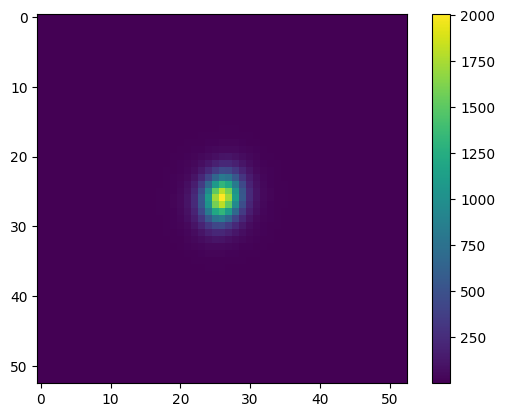

In [ ]:
plt.imshow(ds['noiseless'][idx[0], 0])
plt.colorbar()

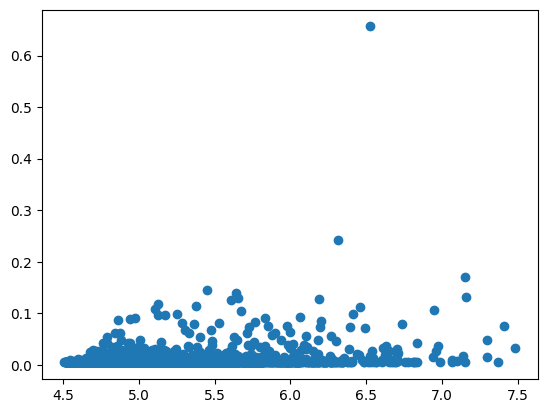

In [ ]:
plt.scatter(np.log10(adjusted_fluxes), (adjusted_fluxes - image_fluxes) / adjusted_fluxes)

In [ ]:
sum(abs(res) > 0.1) / 3000

tensor(0.0050)

In [ ]:
res = (adjusted_fluxes - image_fluxes) / adjusted_fluxes
np.argwhere(abs(res) > 0.5)

tensor([[1077]])

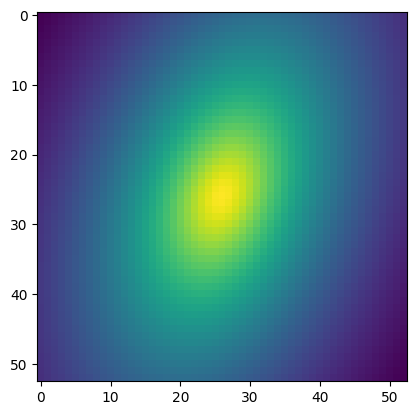

In [ ]:
plt.imshow(ds['noiseless'][1077,0])

In [ ]:

# check indices match
assert np.all(np.isin(ds["indices"].numpy(), final_table["galtileid"]))

# check fluxes match
assert np.allclose(cat_fluxes, saved_fluxes, rtol=1e-4, atol=0)
assert np.allclose(image_fluxes, saved_fluxes, rtol=2e-1, atol=0)